In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, \
    mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [3]:
df = pd.read_csv("../data/eda_clean_sample.csv", parse_dates=['TransactionMonth','VehicleIntroDate'], low_memory=False)

# Create targets 
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
# Severity only for claimants
df['ClaimSeverity'] = df['TotalClaims'].where(df['HasClaim']==1, np.nan)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

print(df.shape)
df[['HasClaim','ClaimSeverity','Margin']].describe()


(1000098, 57)


,HasClaim,ClaimSeverity,Margin
count,1.000098e+06,2788.000000,1.000098e+06
mean,2.787727e-03,23273.387063,-2.955694e+00
std,5.272531e-02,38719.512597,2.367137e+03
min,0.000000e+00,139.043860,-3.928486e+05
25%,0.000000e+00,1680.728070,0.000000e+00
50%,0.000000e+00,6140.350877,2.157687e+00
75%,0.000000e+00,30480.991228,2.192982e+01
max,1.000000e+00,393092.105263,6.528260e+04


In [4]:
# Example features 
base_features = [
    'Province','PostalCode','Gender','VehicleType','RegistrationYear',
    'make','Model','SumInsured','CalculatedPremiumPerTerm','TermFrequency'
]

# Create simple engineered features
df['VehicleAge'] = (pd.to_datetime('today').year - pd.to_numeric(df['RegistrationYear'], errors='coerce')).clip(lower=0)
df['LogSumInsured'] = np.log1p(df['SumInsured'].fillna(0))

# Keep only features and drop rows with missing target for severity model
model_df = df.copy()


In [5]:
train_df, test_df = train_test_split(model_df, test_size=0.2, stratify=model_df['HasClaim'], random_state=RANDOM_STATE)

print(train_df.shape, test_df.shape)


(800078, 59) (200020, 59)


In [7]:
# Define features lists
num_features = ['VehicleAge','LogSumInsured','CalculatedPremiumPerTerm']
cat_features = ['Province','Gender','VehicleType']

# numeric pipeline
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical pipeline (one-hot) — FIXED
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
    ],
    remainder='drop'
)


In [8]:
# Prepare data
X_train = train_df[num_features + cat_features]
y_train = train_df['HasClaim']
X_test = test_df[num_features + cat_features]
y_test = test_df['HasClaim']

# Baseline logistic
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
pipe_lr.fit(X_train, y_train)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
print("Logistic ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("Logistic PR AUC:", average_precision_score(y_test, y_proba_lr))

# Strong model: XGBoost
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=4))
])
pipe_xgb.fit(X_train, y_train)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]
print("XGB ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("XGB PR AUC:", average_precision_score(y_test, y_proba_xgb))


Logistic ROC AUC: 0.6118672445724878
Logistic PR AUC: 0.006036625586061939
XGB ROC AUC: 0.8878794081527337
XGB PR AUC: 0.01673514786995103


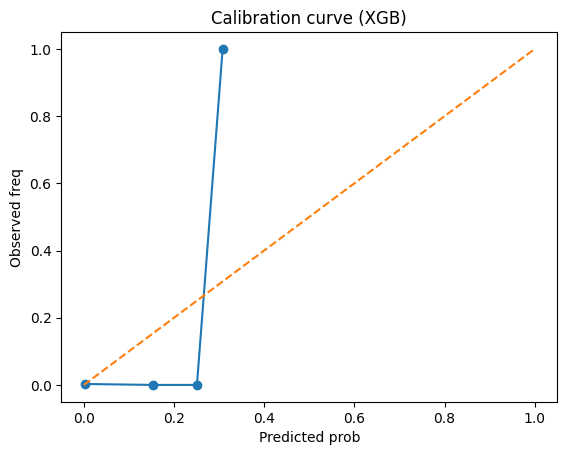

Calibrated XGB ROC AUC: 0.886377675840484


In [9]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
prob_true, prob_pred = calibration_curve(y_test, y_proba_xgb, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], '--')
plt.title('Calibration curve (XGB)')
plt.xlabel('Predicted prob')
plt.ylabel('Observed freq')
plt.show()

# calibrate
calibrator = CalibratedClassifierCV(pipe_xgb, cv=3, method='isotonic')
calibrator.fit(X_train, y_train)
y_proba_cal = calibrator.predict_proba(X_test)[:,1]
print("Calibrated XGB ROC AUC:", roc_auc_score(y_test, y_proba_cal))


In [13]:
sev_train = train_df[train_df['HasClaim']==1].copy()
sev_test = test_df[test_df['HasClaim']==1].copy()

# target transform (log) to reduce skew
sev_train['y_log'] = np.log1p(sev_train['TotalClaims'])
sev_test['y_log'] = np.log1p(sev_test['TotalClaims'])

X_train_sev = sev_train[num_features + cat_features]
y_train_sev = sev_train['y_log']
X_test_sev = sev_test[num_features + cat_features]
y_test_sev = sev_test['y_log']

pipe_xgb_reg = Pipeline([
    ('pre', preprocessor),
    ('reg', xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=4, objective='reg:squarederror'))
])

pipe_xgb_reg.fit(X_train_sev, y_train_sev)
y_pred_log = pipe_xgb_reg.predict(X_test_sev)
y_pred = np.expm1(y_pred_log)  # back-transform

# evaluation on original scale
rmse = root_mean_squared_error(sev_test['TotalClaims'], y_pred)
mae = mean_absolute_error(sev_test['TotalClaims'], y_pred)
r2 = r2_score(sev_test['TotalClaims'], y_pred)

print("Severity RMSE:", rmse)
print("Severity MAE:", mae)
print("Severity R2:", r2)


Severity RMSE: 38442.83980059603
Severity MAE: 15500.685199794627
Severity R2: 0.12470947934793619


In [15]:
# calibrated probabilities or raw probs as chosen
p_claim = (calibrator.predict_proba(X_test)[:,1] if 'calibrator' in globals() else pipe_xgb.predict_proba(X_test)[:,1])

# For severity on all test rows, we need predicted severity for all rows (set 0 for no-claim OR use model to predict severity for every row)
# Strategy: predict severity for everyone (model trained on claimants) 
sev_pred_all_log = pipe_xgb_reg.predict(X_test)  # predicts log1p severity for everyone
sev_pred_all = np.expm1(sev_pred_all_log)

expected_cost = p_claim * sev_pred_all

# Suggested premium formula
expense_loading = 0.10  
profit_margin = 0.10   

expected_cost_mean = np.nanmean(expected_cost)
suggested_premium = expected_cost * (1 + expense_loading + profit_margin)

print("Average expected cost (per policy):", expected_cost_mean)
print("Sample suggested premium (first 10):", suggested_premium[:10])


Average expected cost (per policy): 44.59082504319772
Sample suggested premium (first 10): [6.47744742e-03 8.98240276e-03 6.97136553e+00 3.44566543e+02
 2.74980829e+00 6.02414847e+01 1.05875971e+01 5.59528055e-02
 7.36488165e-02 2.20854694e+01]


In [16]:
# attach results to test_df copy for comparison
test_out = test_df.reset_index(drop=True).copy()
test_out['p_claim'] = p_claim
test_out['pred_severity'] = sev_pred_all
test_out['expected_cost'] = expected_cost
test_out['suggested_premium'] = suggested_premium

# Aggregate comparison
print("Avg actual premium:", test_out['TotalPremium'].mean())
print("Avg suggested premium:", test_out['suggested_premium'].mean())
print("Average predicted expected cost:", test_out['expected_cost'].mean())
print("Actual average margin:", (test_out['TotalPremium'] - test_out['TotalClaims']).mean())

Avg actual premium: 61.60202572107906
Avg suggested premium: 53.50899005183726
Average predicted expected cost: 44.59082504319772
Actual average margin: -2.6915499388987945


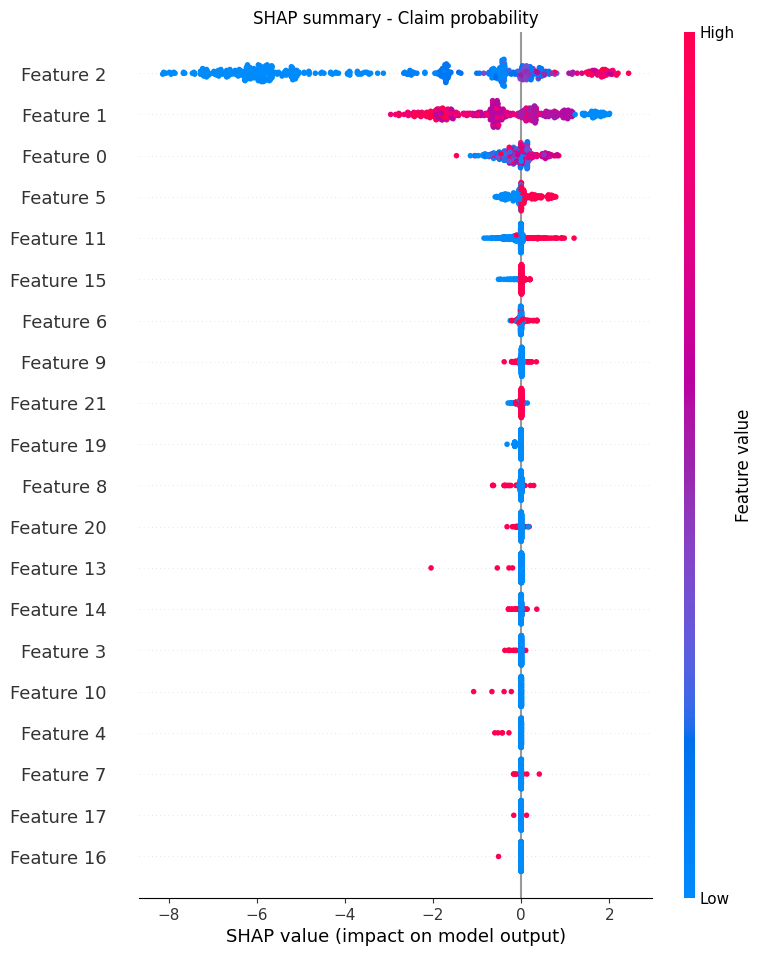

In [18]:
# For classification (XGBoost) — use explainer on preprocessed data (shap works with raw model + raw preprocessor separately)
# Create a small sample to speed up shap
X_sample = X_test.sample(min(500, len(X_test)), random_state=RANDOM_STATE)

# Need to transform sample with preprocessor pipeline to arrays
X_trans = preprocessor.fit_transform(train_df[num_features+cat_features])  # fit preprocessor to full training data
# Refit models after preprocessor fitting is optional; re-use trained pipelines but build SHAP using underlying XGBoost booster

# SHAP with XGBoost (classification)
explainer = shap.Explainer(pipe_xgb.named_steps['clf'])

# Get transformed feature names for SHAP plotting (only if you want readable names)
transformed_X_test = preprocessor.transform(X_sample)
model_booster = pipe_xgb.named_steps['clf']
shap_values = shap.TreeExplainer(model_booster).shap_values(transformed_X_test)

shap.summary_plot(shap_values, transformed_X_test, show=False)
plt.title('SHAP summary - Claim probability')
plt.savefig('../reports/images/shap_claim_prob.png', dpi=150)
plt.show()


In [20]:
# Save pipelines
joblib.dump(pipe_xgb, '../models/pipe_xgb_claim_prob.joblib')
joblib.dump(pipe_xgb_reg, '../models/pipe_xgb_severity.joblib')
# Save preprocessor if separate
joblib.dump(preprocessor, '../models/preprocessor.joblib')

# Save feature lists and config
import json
config = {
    'num_features': num_features,
    'cat_features': cat_features,
    'expense_loading': expense_loading,
    'profit_margin': profit_margin,
    'random_state': RANDOM_STATE
}
with open('../models/model_config.json','w') as f:
    json.dump(config, f, indent=2)


In [21]:
report = {
    'classification': {
        'roc_auc': roc_auc_score(y_test, y_proba_xgb),
        'pr_auc': average_precision_score(y_test, y_proba_xgb)
    },
    'severity': {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    },
    'pricing': {
        'avg_expected_cost': float(expected_cost_mean),
        'avg_suggested_premium': float(test_out['suggested_premium'].mean())
    }
}
import json
with open('../reports/modeling_summary.json','w') as f:
    json.dump(report, f, indent=2)
